In [42]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot, u_statistics as u_stats
import salem
import numpy.ma as ma
from scipy import stats, ndimage

import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress, pearsonr
import pickle as pkl
import glob
from scipy.stats import binned_statistic_2d

import math

from endgame import hist2d

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
ml = 0.5
lonsample=[(-78.25+ml, -73.75), (-77.25+ml, -72.75), (-75.5+ml, -71.0), (-66.25+ml, -61.75)]

In [5]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [6]:
corr_all

<xarray.Dataset>
Dimensions:    (dayofyear: 365, latitude: 101, longitude: 65)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 ...
  * dayofyear  (dayofyear) int64 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    pval       (dayofyear, latitude, longitude) float64 ...
    r          (dayofyear, latitude, longitude) float64 ...
    slope      (dayofyear, latitude, longitude) float64 ...
    intercept  (dayofyear, latitude, longitude) float64 ...
Attributes:
    years:    [1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 19...

In [7]:
def readERA(var, load=False):
    if load:
        u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_*.nc')[0]).load()
    else:
        u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    #ipdb.set_trace()
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)

    return u200orig

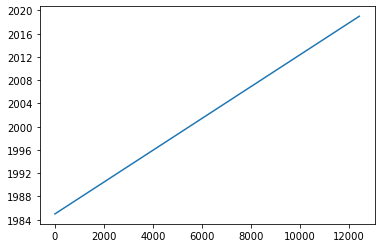

In [11]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).load()
plt.plot(era.time.values)

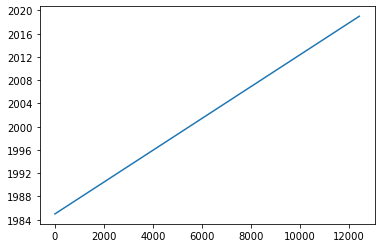

In [12]:
eraq8 = readERA('v550')
eraq8 = eraq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraq8['time.year']>=1985)&(eraq8['time.year']<=2018))).load()
eravv8 = readERA('u550')
eravv8 = eravv8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eravv8['time.year']>=1985)&(eravv8['time.year']<=2018))).load()
eraqq8 = readERA('q550')
eraqq8 = eraqq8.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraqq8['time.year']>=1985)&(eraqq8['time.year']<=2018))).load()*1000

ws = np.sqrt((eraq8['v'].values**2+eravv8['u550'].values**2))
eraq8['v'].values=ws*eraqq8['q550'].values
plt.plot(eraq8.time.values)

In [13]:
del eravv8
del eraqq8

12416


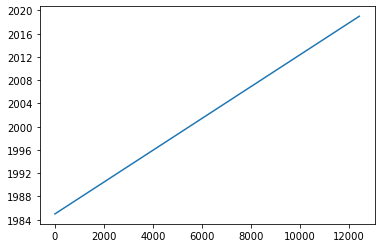

In [14]:
eraT = readERA('tcwv').load()
eraT = eraT['tcwv'].sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((eraT['time.year']>=1985)&(eraT['time.year']<=2018)))
plt.plot(eraT.time.values)
print(len(eraT.time))

12418


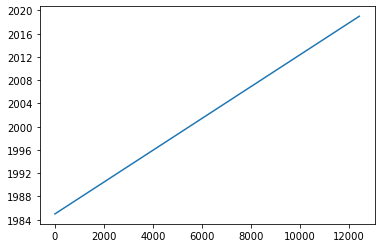

In [15]:
erav = readERA('v850')
erav = erav.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018))).load()
plt.plot(erav.time.values)
print(len(erav.time))

12418


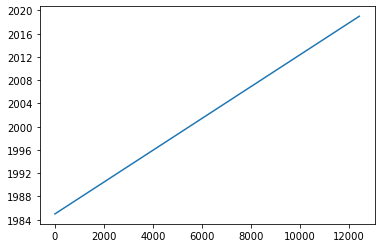

In [16]:
erar = readERA('r850')
erar = erar.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).sel(time=((erar['time.year']>=1985)&(erar['time.year']<=2018))).load()
plt.plot(erar.time.values)
print(len(erar.time))

In [17]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [18]:
eraT = erav.salem.transform(eraT)

In [19]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [20]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-40ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))/100

In [21]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [22]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

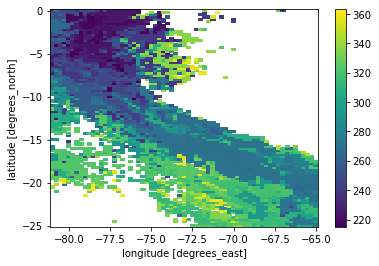

In [23]:
dic['start_3d'].plot()

In [24]:
# lat_pick = corr_all.latitude#.values
# corr_start = dic['start_3d']
# corr_end = dic['end_5d']

# for r in regions.keys():
#     mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
#     sedoy = (np.nanmedian(corr_start.where((topo_on_g>h) & mask)), np.nanmedian(corr_end.where((topo_on_g>h) & mask)))
#     if r == 'southern':
#         plt.pcolormesh(corr_start.where((topo_on_g>h) & mask))
#     print(r, datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[0] - 1), datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[1] ))
#     regions[r].append(sedoy)

In [25]:
# use this, defines narrower season window for region
lat_pick = corr_all.latitude.values
corr_start = dic['start_3d']
corr_end = dic['end_5d']
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]).values, np.mean(corr_end[mask]).values)
    #print(r, datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[0] - 1), datetime.datetime(2017, 1, 1) + datetime.timedelta(sedoy[1] ))
    regions[r].append(sedoy)

In [26]:
#pkl.dump(regions, open("/home/ck/DIR/cornkle/data/HUARAZ/saves/corr_GRIDSAT-15_start_end_regionMean.p", "wb"))

In [27]:
posgridg = np.intersect1d(eraT.time.values, tir_doypick.time.values)

grid200 = tir_doypick.sel(time=posgridg)/100
posgrid = np.intersect1d(chirps_doypick.time.values, grid200.time.values)
grid200 = grid200.sel(time=posgrid)
posgrid = np.intersect1d(eraq8.time.values, grid200.time.values)

grid200 = grid200.sel(time=posgrid)
u200ca = era.sel(time=posgrid)
cau200 = chirps_doypick.sel(time=posgrid)

In [28]:
v850ca = erav.sel(time=posgrid)
q850ca = eraq8.sel(time=posgrid)
r850ca = erar.sel(time=posgrid)
Tca = eraT.sel(time=posgrid)

In [29]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2, alternative):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [30]:
drymeans = {'3': [], '5': [], '7': []}
wetmeans = {'3': [], '5': [], '7': []}
dryall = {'3': [], '5': [], '7': []}
wetall =  {'3': [], '5': [], '7': []}
clim_means =  {'3': [], '5': [], '7': []}

drystd ={'3': [], '5': [], '7': []}
wetstd = {'3': [], '5': [], '7': []}
climstd = {'y': [], 'm': [], 'd': []}
tstats = {'3' : [], '5' : [], '7': [] }

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    for snb in ['3', '5', '7']:
        
    
        #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_v2_perPix_split.p", "rb"))
        dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_v2.p", "rb"))
        #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+r+"_dw_spellDates_0.15perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))

        dd = dic['dry'+snb]
        ww = dic['wet'+snb]

        alls = regions[r]
        doys_s = np.round(alls[1][0])
        doys_e = np.round(alls[1][1])
        era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load()
        tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
        chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load()
        eraq_region = q850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e)))*1000


        xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
        xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
        xxtc = tcwv_region.mean(['latitude', 'longitude'])
        xxq8 = eraq_region.mean(['latitude', 'longitude'])
        
       
        
        chy = xxch.groupby('time.year').mean().std('year').values
        tcy = xxtc.groupby('time.year').mean().std('year').values
        u2y = xxu2.groupby('time.year').mean().std('year').values
        climstd['y'].append((chy,u2y,tcy))
        
        chm = xxch.resample(time='m').mean().std('time').values
        tcm = xxtc.resample(time='m').mean().std('time').values
        u2m = xxu2.resample(time='m').mean().std('time').values
        climstd['m'].append((chm,u2m,tcm))
        
        chd = xxch.std('time').values
        tcd = xxtc.std('time').values
        u2d = xxu2.std('time').values
        climstd['d'].append((chd,u2d,tcd))

        drytir = np.intersect1d(xxch.time.values, dd)
        wettir = np.intersect1d(xxch.time.values, ww)

        xxchd = float(xxch.sel(time=drytir).mean('time').values)
        xxu2d = xxu2.sel(time=drytir)#.mean('time').values)
        xxq8d = xxtc.sel(time=drytir)#.mean('time').values)
        
        dryall[snb].append( (xxch.sel(time=drytir).values, xxu2.sel(time=drytir).values,  xxtc.sel(time=drytir).values) )
        wetall[snb].append( (xxch.sel(time=wettir).values, xxu2.sel(time=wettir).values,  xxtc.sel(time=wettir).values) )
        clim_means[snb].append((xxch.mean('time').values, xxu2.mean('time').values,  xxtc.mean('time').values))

        xxchw = float(xxch.sel(time=wettir).mean('time').values)
        xxu2w = xxu2.sel(time=wettir)#.mean('time').values)
        xxq8w = xxtc.sel(time=wettir)#.mean('time').values)
                      
        pdu =  welch_ttest(xxu2w.values, xxu2d.values, "equal") 
        pdt =  welch_ttest(xxq8w.values, xxq8d.values, "equal") 
                      
        #ipdb.set_trace()
                      
        xxu2d = float(xxu2d.mean('time').values)
        xxu2w = float(xxu2w.mean('time').values)
        xxq8w = float(xxq8w.mean('time').values)
        xxq8d = float(xxq8d.mean('time').values)

        xxchds = float(xxch.sel(time=drytir).std('time').values)
        xxu2ds = float(xxu2.sel(time=drytir).std('time').values)
        xxq8ds = float(xxtc.sel(time=drytir).std('time').values)

        xxchws = float(xxch.sel(time=wettir).std('time').values)
        xxu2ws = float(xxu2.sel(time=wettir).std('time').values)
        xxq8ws = float(xxtc.sel(time=wettir).std('time').values)


        drymeans[snb].append( (xxchd, xxu2d, xxq8d) )
        wetmeans[snb].append( (xxchw, xxu2w, xxq8w ) )
        drystd[snb].append( (xxchds, xxu2ds, xxq8ds))
        wetstd[snb].append( (xxchws, xxu2ws, xxq8ws ) )
        tstats[snb].append((pdu, pdt))

In [31]:
scadir = {}
for ids, r in enumerate(regions.keys()):
    print(r)
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    
    era_region = u200ca['u'].where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e)))

    erav_region = v850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e)))
    eraq_region = q850ca['v'].where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e)))
    #eraq_region = Tca.where((topo_on_g<1500)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    tcwv_region = Tca.where((topo_on_g<h)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.where((topo_on_g>h)).sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e)))
    #ipdb.set_trace()
    xxch = chirps_region.mean(['latitude', 'longitude']).groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude']).groupby(era_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude']).groupby(erav_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude']).groupby(eraq_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    xxtcw = tcwv_region.mean(['latitude', 'longitude']).groupby(tcwv_region['time.year']).mean()#.rolling(year=3, min_periods=1, center=True).mean()
    
    scadir[r] = [xxch.values, xxu2.values, xxv8.values, xxq8.values, xxtcw]
    
allyears = np.unique(xxch['year'])

equatorial
transition
central
southern


In [32]:
def weighted_regress(bins,data, pval=None):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    weight=None
    if pval is not None:
        inval = np.array(pval)#[pos]
        weight = inval / np.sum(inval)
    X = sm.add_constant(inbins)

    wls_model = sm.WLS(indata,X, missing='drop').fit() # #, weights=weight
    
    r, pval = stats.pearsonr(bins, data)
    
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    rpearson = r
    ppearson = pval
    return intercept, slope, r_value,rpearson, ppearson

In [33]:
import seaborn as sns
colord = sns.color_palette("magma_r")

In [45]:


def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [52]:
def multi_regression(X,Y,Z):
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    #weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, missing='drop').fit()

    # Print the summary
    print(model.summary())

    #print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('Multi regression results, raw')
    print(anova_results)

    #plt.show()
    ################################################################
    return model

In [35]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 3
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    #print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    #plt.show()
    ################################################################
   # ipdb.set_trace()
    intercept = model.params[0] #  intercept
    slope_x = model.params[1] #  slope
    slope_y = model.params[2]
    r_value = model.rsquared  #rsquared

    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins,
        'slope_x' : slope_x,
        'slope_y' : slope_y,
        'intercept' : intercept,
        'rval' : r_value,
    }
    
    return odic

In [57]:
tstats

{'3': [(   T statistic          df  pvalue 2 sided  Difference in mean        lb  \
   0    -0.369055  937.699884         0.71217            -0.17375 -1.097691   
   
            ub  
   0  0.750191  ,
      T statistic          df  pvalue 2 sided  Difference in mean       lb  \
   0     3.266153  913.156938        0.001131            0.746067  0.29777   
   
            ub  
   0  1.194364  ),
  (   T statistic          df  pvalue 2 sided  Difference in mean        lb  \
   0    -2.440829  925.339788         0.01484           -1.183248 -2.134629   
   
            ub  
   0 -0.231866  ,
      T statistic          df  pvalue 2 sided  Difference in mean        lb  \
   0     4.702529  930.941824        0.000003            0.873676  0.509063   
   
            ub  
   0  1.238289  ),
  (   T statistic          df  pvalue 2 sided  Difference in mean        lb  \
   0    -6.535845  594.446432    1.361816e-10           -3.328924 -4.329236   
   
            ub  
   0 -2.328612  ,
      T st

r u2, tcw removed (-0.21792219523126447, 8.865052799479601e-98)
r tcw, u2 removed (0.2003297847024616, 1.288053678855826e-82)
r u2 pearson (-0.2099742793593191, 9.110746040076259e-91)
r tcw pearson (0.19158514008005198, 1.3387296434296277e-75)
r tcw versus u (0.020187052143375184, 0.054746173643004055)
                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.082
Model:                            WLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     406.7
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          7.22e-170
Time:                        17:45:13   Log-Likelihood:                -26930.
No. Observations:                9055   AIC:                         5.387e+04
Df Residuals:                    9052   BIC:                         5.389e+04
Df Model:                           2                           

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


r u2, tcw removed (-0.22929974938795594, 3.846476147135865e-95)
r tcw, u2 removed (0.25295970082375235, 4.765794102450134e-116)
r u2 pearson (-0.24986092869417173, 3.416170823317429e-113)
r tcw pearson (0.2715180755967059, 4.270487379799141e-134)
r tcw versus u (-0.1126232977620196, 8.173765941473304e-24)
                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.122
Model:                            WLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     553.1
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          1.33e-225
Time:                        17:45:16   Log-Likelihood:                -22870.
No. Observations:                7933   AIC:                         4.575e+04
Df Residuals:                    7930   BIC:                         4.577e+04
Df Model:                           2                        

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


r u2, tcw removed (-0.2835666254152434, 1.678476321682806e-132)
r tcw, u2 removed (0.32351233949642494, 4.253257991380371e-174)
r u2 pearson (-0.34205001057973444, 1.021981124161825e-195)
r tcw pearson (0.3745444669760417, 2.661829438389618e-237)
r tcw versus u (-0.23009006945748436, 1.1282338665283428e-86)
                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.209
Model:                            WLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     948.0
Date:                Wed, 06 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:45:17   Log-Likelihood:                -18147.
No. Observations:                7161   AIC:                         3.630e+04
Df Residuals:                    7158   BIC:                         3.632e+04
Df Model:                           2                      

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


r u2, tcw removed (-0.441050056337089, 3.0940545065721704e-237)
r tcw, u2 removed (0.3347736568637902, 2.7784771789645324e-131)
r u2 pearson (-0.5052497332183922, 1.6e-322)
r tcw pearson (0.4231363651393776, 1.3771612349231e-216)
r tcw versus u (-0.2903071604516714, 9.102094425871932e-98)
                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.339
Model:                            WLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     1281.
Date:                Wed, 06 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:45:19   Log-Likelihood:                -10782.
No. Observations:                5004   AIC:                         2.157e+04
Df Residuals:                    5001   BIC:                         2.159e+04
Df Model:                           2                                         

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each 

Text(0, 4, 'b)')

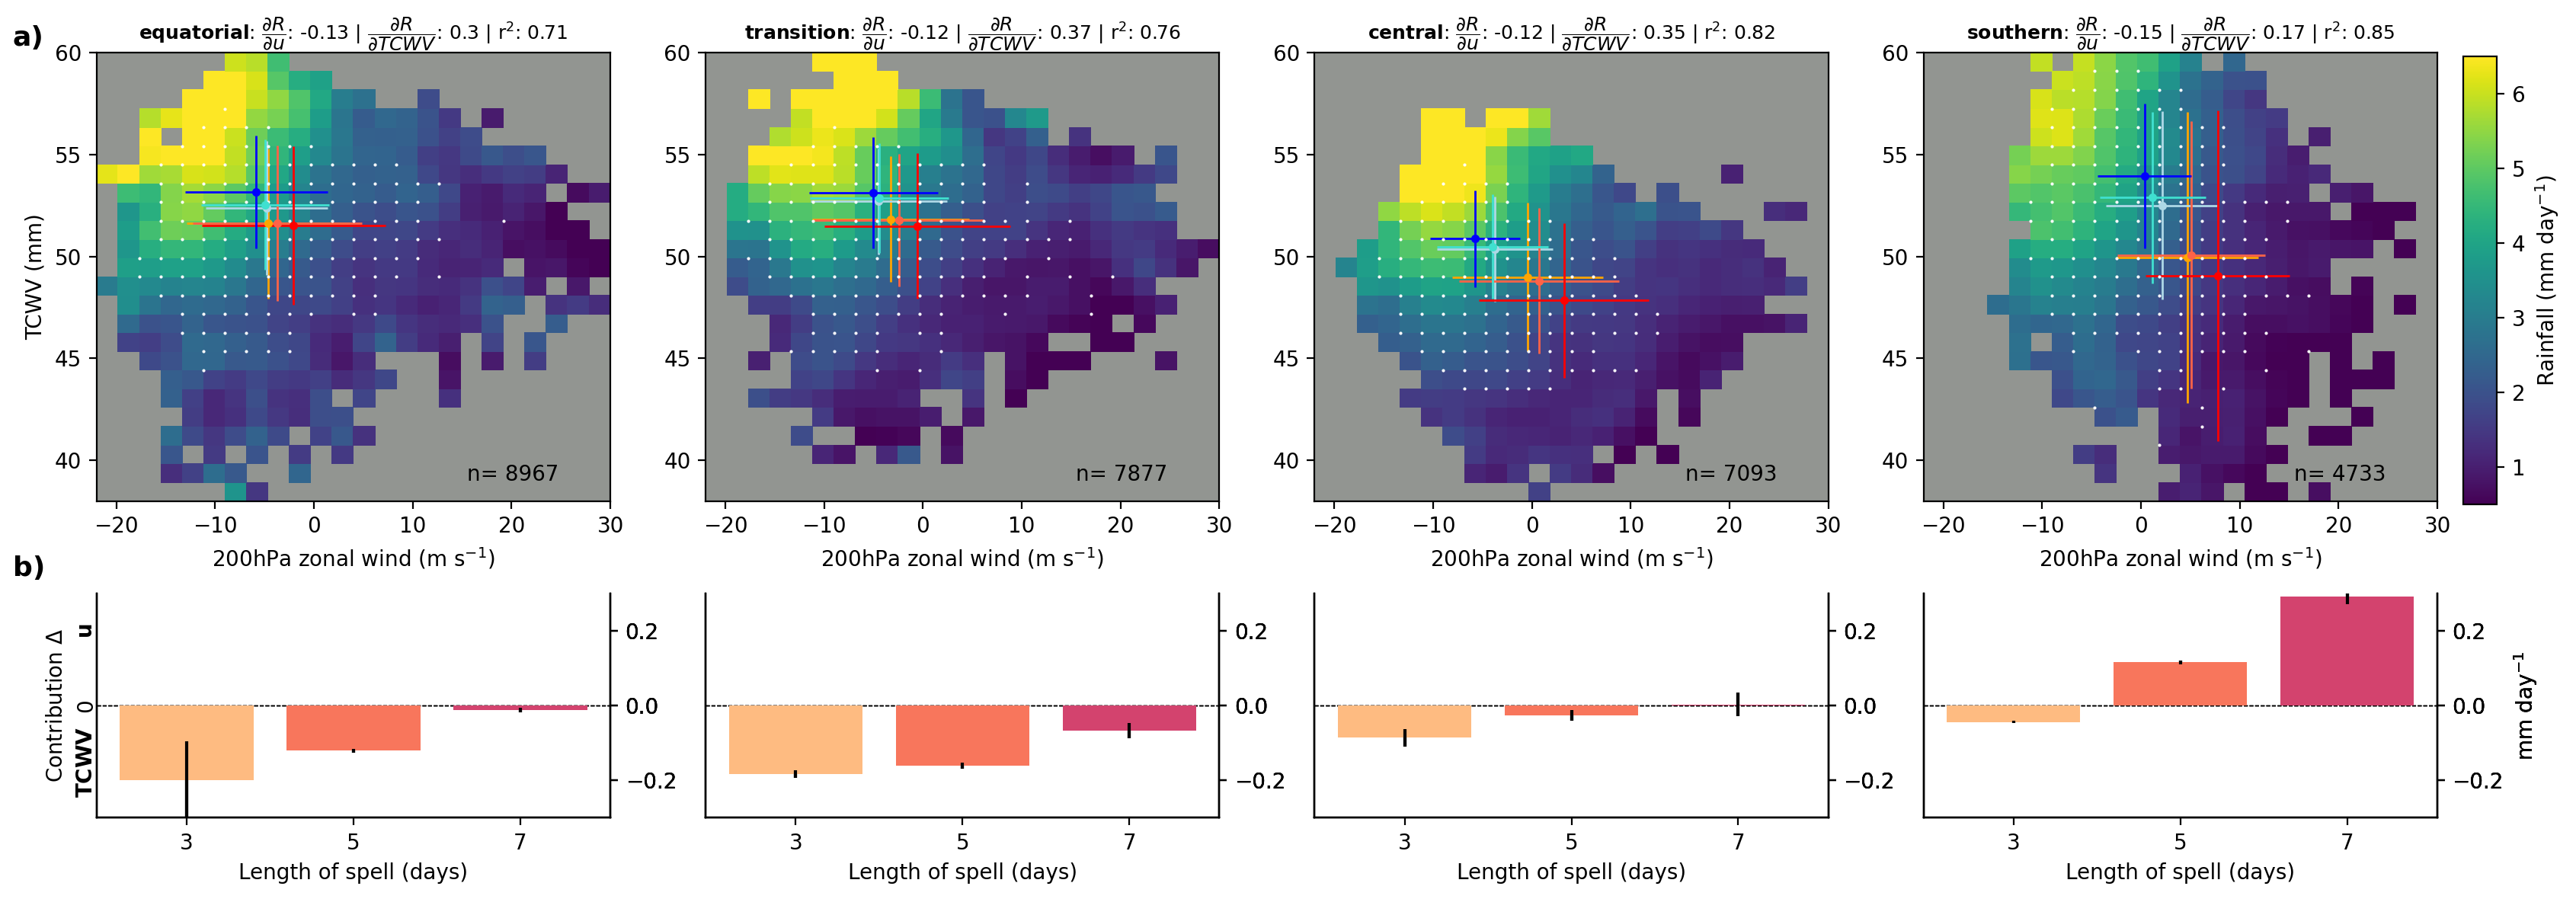

In [56]:
slopes2d = {}  #u, then TCW
# Create 4x4 Grid

f = plt.figure(figsize=(17,6), dpi=200)
gs = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2,1])#, hspace=0.25)
gs2 = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2,1])#, hspace=0.25)#, wspace=0.2)

for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))

    erav_region = v850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))
    eraq_region = q850ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((q850ca['time.dayofyear']>=doys_s) | (q850ca['time.dayofyear']<=doys_e))).load().where((topo_on_g<h))
    tcwv_region = Tca.where((topo_on_g<1500)).sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(lonsample[ids][0], lonsample[ids][1]), time =((Tca['time.dayofyear']>=doys_s) | (Tca['time.dayofyear']<=doys_e)))
    
    
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().where((topo_on_g>h))
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean()#.rolling(year=3, min_periods=2, center=True).mean()
    xxu2 = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean()
    xxv8 = erav_region.mean(['latitude', 'longitude'])#.groupby(erav_region['time.year']).mean()
    xxq8 = eraq_region.mean(['latitude', 'longitude'])#.groupby(eraq_region['time.year']).mean()
    xxtc = tcwv_region.mean(['latitude', 'longitude'])
  #  ipdb.set_trace()
    
    ru = u_stats.pcor(xxch.values,xxu2.values,xxtc.values)
    print('r u2, tcw removed', ru)
    
    rt = u_stats.pcor(xxch.values,xxtc.values,xxu2.values)
    print('r tcw, u2 removed', rt)
    
    rru = pearsonr(xxch.values,xxu2.values)
    print('r u2 pearson', rru)
    
    rrt = pearsonr(xxch.values,xxtc.values)
    print('r tcw pearson', rrt)
    
    rrd = pearsonr(xxu2.values,xxtc.values)
    print('r tcw versus u', rrd)
    
    
    model = multi_regression(xxu2.values, xxtc.values,xxch.values)
    
    

    ax = f.add_subplot(gs[0,ids])

    
    q1 = 0.1
    q2 = 99.9
    sbin = np.linspace(np.percentile(xxu2,q1) ,np.percentile(xxu2,q2),19)
    #tbin = np.linspace(np.percentile(xxq8,q1) ,np.percentile(xxq8,q2),19)
    tbin = np.linspace(np.percentile(xxtc,q1) ,np.percentile(xxtc,q2),19)
    
    tbin = np.linspace(38,60,25)
    sbin = np.linspace(-22,30,25)
    
    p1,p2 = np.percentile(xxch,[10,89])

    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)
    
    dicobs = run_small_2d(ret, count, testbins)
    
    ax.set_facecolor('xkcd:grey')
    
    cctar=count.statistic.T
    target = np.sum(count.statistic.T)*0.8 # get threshold with 80% of cases 
    
    for cc in np.unique(cctar)[::-1]:
        
        breaker = np.sum(cctar[cctar>=cc])
        if breaker >= target:
            tests = cc
            break
    
    maskpos = np.where(count.statistic.T>=tests)
    dd = gauss(ret.statistic.T, 0.8) #count.statistic.T #gauss(ret.statistic.T, 0.8)
    pixelval=3
    invalid = count.statistic.T < pixelval
    dd[invalid] = np.nan
#     bigpos = np.where(dd>60)
#     print('bigpos', bigpos)
    mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis',vmax=6.5, vmin=0.5) #vmax=p2-1, vmin=0.5  ##p2-1
    plt.plot(testbins[0][maskpos[1]],testbins[1][maskpos[0]],'.', color='white', markersize=1)
    ax.set_yticks(np.arange(40,61,5).astype(int))
    

    
    wcolors = ['lightblue', 'turquoise', 'blue']
    dcolors = ['orange', 'tomato', 'red']
    for sid, snb in enumerate(['3', '5', '7']):
        dreg = drymeans[snb][ids]
        wreg = wetmeans[snb][ids]
        dregstd = drystd[snb][ids]
        wregstd = wetstd[snb][ids]
        plt.errorbar(dreg[1]+1, dreg[2]+1, yerr=dregstd[2], xerr=dregstd[1], color=dcolors[sid], marker='o', elinewidth=1, ms=3)
        plt.errorbar(wreg[1]+1, wreg[2]+1, yerr=wregstd[2], xerr=wregstd[1], color=wcolors[sid], marker='o', elinewidth=1, ms=3)
#     if ids in [3]:
#         plt.colorbar(mp, label='Rainfall (mm day$^{-1}$)')
#     else:
#         plt.colorbar(mp, label='')
    if ids in [0,1,2,3]:
        plt.xlabel( r'200hPa zonal wind (m s$^{-1}$)')  #'200hPa zonal wind (m s$^{-1}$)'
    if ids in [0]:
        plt.ylabel('TCWV (mm)')
    
#     if r == 'southern':
#         dicobs['slope_y']= 0.3674
        
    plt.title( r'$\bf{'+r+'}$'+r': $\dfrac{\partial R}{\partial u}$: '+ str(np.round(dicobs['slope_x'],2)) + \
              r' | $\dfrac{\partial R}{\partial TCWV}$: '+ str(np.round(dicobs['slope_y'],2))+ r' | r$^{2}$: '+str(np.round(dicobs['model'].rsquared,2)), fontsize=9)
    # #+ r'$\pm$'+str(np.round(dicobs['model'].bse[1],2)) + r'$\pm$'+str(np.round(dicobs['model'].bse[2],2))
    plt.xlim(testbins[0][0],testbins[0][-1])
    plt.ylim(testbins[1][0],testbins[1][-1])
   
    #ipdb.set_trace()
    
    
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    #plt.text(15,34.5,'n days='+str(math.trunc(np.sum(count.statistic))))
    plt.text(x_max-14.5,y_min+1,'n= '+str(math.trunc(np.sum(count.statistic))))
    #ipdb.set_trace()
    
    
    slopes2d[r] = (dicobs['slope_x'],dicobs['slope_y'],dicobs['intercept'], dicobs['model'].bse[1], dicobs['model'].bse[2]) 
    
    df = pd.DataFrame.from_dict(slopes2d)
    #df.to_csv('/home/ck/DIR/cornkle/data/HUARAZ/saves/scaling_TCW_uwind_from2dhist.csv')

    
################################# bottom plot    
    
#ax1 = f.add_subplot(gs2[2,:])
shi = [-0.1,0,0.1,0.2]
step = [0, 0.25, 0.5]



for ids, r in enumerate(regions.keys()):
    for dnid, dnb in enumerate(['3','5', '7']):

#         dreg = drymeans[dnb][ids]
#         wreg = wetmeans[dnb][ids]
#         dregstd = drystd[dnb][ids]
#         wregstd = wetstd[dnb][ids]

        ax1 = f.add_subplot(gs[1,ids])

        u2stats  = tstats[dnb][ids][0]
        tcstats = tstats[dnb][ids][1]

        statsi = slopes2d[r]
        slopeu = statsi[0]
        slopet = statsi[1]
        inter = statsi[2]

        erru = statsi[3]
        errt = statsi[4]
        #ipdb.set_trace()
        um = u2stats["Difference in mean"] *slopeu
        tm = tcstats["Difference in mean"] *slopet
        
        erru = np.vstack(((abs(u2stats["Difference in mean"])-abs(u2stats["lb"]))*slopeu,  (abs(u2stats["ub"])-abs(u2stats["Difference in mean"]))*slopeu))
        errt = np.vstack(((abs(tcstats["Difference in mean"])-abs(tcstats["lb"]))*slopet,  (abs(tcstats["ub"])-abs(tcstats["Difference in mean"]))*slopet))
        #ipdb.set_trace()
        upval = u2stats["pvalue 2 sided"].values
        tpval = tcstats["pvalue 2 sided"].values
        
        mdiff = um-tm
        #ipdb.set_trace()
        errdiff = np.max(np.array([erru[0]-errt[1], errt[0]-erru[1]]))/2
        #ub = u2stats["ub"]*slopeu - tcstats["ub"]*slopet)
        
        #errs = np.vstack((lb,ub))
        
        if upval <=0.05:
            uecol = 'k'
        else:
            uecol = 'grey'
        if tpval <=0.05:
            tecol = 'k'
        else:
            tecol = 'grey'

        #ipdb.set_trace()
#         bar1 = ax1.bar(ids+shi[0]+step[dnid], um, color='r', width=0.1, yerr=erru, linewidth=0.5, ecolor=uecol)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], tm, color='lightblue', width=0.1, yerr=errt, ecolor=tecol)



#         bar1 = ax1.bar(ids+shi[0]+step[dnid], (wreg[1]-dreg[1])*slopeu, color='r', width=0.1, yerr=((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu), linewidth=0.5)
#         bar2 = ax1.bar(ids+shi[1]+step[dnid], (wreg[2]-dreg[2])*slopet, color='lightblue', width=0.1, yerr=((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet))

#         ub = (wreg[1]-dreg[1])*slopeu
#         tb = (wreg[2]-dreg[2])*slopet
#         udiff = ((wreg[1]-dreg[1])*(slopeu+erru)) - ((wreg[1]-dreg[1])*slopeu)
#         tdiff = ((wreg[2]-dreg[2])*(slopet+errt)) - ((wreg[2]-dreg[2])*slopet)

#         if mdiff < 0:
#             col = 'lightblue'
#         else:
#             col = 'grey'
        if ids == 0:
            lab = dnb+'-day spell'
        else:
            lab = ''
        bar2 = ax1.bar(0+step[dnid], mdiff, color=colord[dnid], width=0.2, yerr=errdiff, label=lab)

        ax1.axhline(0, linestyle='dashed', color='k', linewidth=0.5)
        ax1.set_ylim(-0.3,0.3)
        ax1.set_xticks(step)
        ax1.set_xticklabels(['3', '5', '7'])
        ax1.set_xlabel('Length of spell (days)')
        if ids == 0:
            ax1.set_ylabel('Contribution $\Delta$')
            ax1.set_yticks([-0.15, 0, 0.2])
            ax1.set_yticklabels([r'$\bf{TCWV}$', '0', r'$\bf{u}$'], rotation=90, ha='center', rotation_mode='anchor')
            ax1.tick_params(axis='y', length=0, pad=6)
        else:
            ax1.set_yticks([])
        ax1.spines['top'].set_visible(False)
        
        
        ax2 = ax1.twinx()
        ax2.bar(0+step[dnid], mdiff, color=colord[dnid], width=0.2, yerr=errdiff, label=lab)
        ax2.set_yticks([-0.2, 0, 0.2])
        ax2.set_ylim(-0.3,0.3)
        ax2.spines['top'].set_visible(False)
        if ids ==3:
            ax2.set_ylabel('mm day$^{-1}$')

        #ax1.margins(x=1)
#     if ids == 0:
#         plt.legend(loc='upper left', fontsize=8, bbox_to_anchor=(0.01, 1.3), framealpha=1)
   
#plt.subplots_adjust(wspace=0.11, hspace=0.15)   
plt.tight_layout()

f.subplots_adjust(right=0.94)
cax = f.add_axes([0.95,0.44,0.013,0.49])
f.colorbar(mp, cax, label='Rainfall (mm day$^{-1}$)')
#plt.tight_layout()
#cbar = f.colorbar(mapp, cax, format='%1.1f',label=r'g kg$^{-1}$')
plt.annotate('a)', xy=(0.005, 0.94), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.005, 0.35), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/tcw_u200_2dhist_origSpells_v3.jpg')